**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 2 Clustering Analysis**

## **Import the libraries and load the player dataset**

First we have to import the necessary libraries to work within our project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import math
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

The dataset coming from the data preparation task is saved on github.

In [2]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

Cloning into 'DataMiningProject'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 489 (delta 20), reused 12 (delta 12), pack-reused 449
Receiving objects: 100% (489/489), 74.80 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (126/126), done.


**Load the players' profile dataset**

In [3]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players

name sex  age  ... age_range   ht_range rank_range
0                 alexander zverev   M   24  ...   [21,27]       >190     top 10
8                      frank moser   M   40  ...       >34       >190   top 1000
13           ruben ramirez hidalgo   M   41  ...       >34  [181,190]    top 500
14                      tommy haas   M   39  ...       >34  [181,190]    top 250
15                toshihide matsui   M   41  ...       >34  [171,180]   top 1000
...                            ...  ..  ...  ...       ...        ...        ...
4253               alexandar lazov   M   29  ...   [28,34]  [181,190]   top 1000
4254                  david o hare   M   27  ...   [21,27]  [181,190]   top 1000
4255                   kuan-yi lee   M   23  ...   [21,27]  [171,180]   top 1000
4256                    ben patael   M   22  ...   [21,27]       >190   top 1000
4257  andres artunedo martinavarro   M   25  ...   [21,27]  [181,190]    top 500

[1600 rows x 32 columns]

In [4]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             1600 non-null   object  
 1   sex              1600 non-null   object  
 2   age              1600 non-null   Int32   
 3   ioc              1600 non-null   object  
 4   ht               1600 non-null   Int32   
 5   hand             1600 non-null   object  
 6   t_won            1600 non-null   Int32   
 7   p_wins           1600 non-null   float64 
 8   wins             1600 non-null   Int32   
 9   p_w_Hard         1600 non-null   float64 
 10  w_Hard           1600 non-null   Int32   
 11  p_w_Clay         1600 non-null   float64 
 12  w_Clay           1600 non-null   Int32   
 13  p_w_Grass        1600 non-null   float64 
 14  w_Grass          1600 non-null   Int32   
 15  p_aces           1600 non-null   float64 
 16  p_double_faults  1600 non-null   float64 


##**Choosing the features and normalization**

Before we apply any clustering algorithm we need to choose the features that we think are the best at describing the players. Then we apply normalization on such features.

We decided to consider mainly the percentages since they describe better the player's attitude on the field (albeit they aren't as much as robust). Since there are a lot of feature, with many of them unrelated, we decided to build three different dataframe to work on during the clustering analysis plus a fourth one which contains all the features.

In [5]:
# retrieve only the numerical features
df_players_numerical = df_players.select_dtypes(["int32", "Int32", "float64"])

# build the dataframe for the clustering analysis
df_clustering_0 = df_players_numerical[["t_won", "p_wins", "rank"]]  # cluster about the strenght of a player
df_clustering_1 = df_players_numerical[["p_w_Hard", "p_w_Clay", "p_w_Grass"]]  # cluster about the performance
df_clustering_2 = df_players_numerical[["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won"]]  # cluster about the playstyle of the player
df_clusters = [df_clustering_0, df_clustering_1, df_clustering_2]

We decided to normalize such features with their z-score by using the scikit-learn StandardScaler.

In [6]:
scaler = StandardScaler()  # z-score scaler
x_clusters = []
df_clusters_scaled = []
for df_clustering in df_clusters:
    x = scaler.fit_transform(df_clustering.values)
    df_clustering_scaled = pd.DataFrame(x, columns=df_clustering.columns, index=df_clustering.index)
    x_clusters.append(x)
    df_clusters_scaled.append(df_clustering_scaled)

df_clusters_scaled[0]

t_won    p_wins      rank
0     7.367218  2.014899 -1.130862
8    -0.439752  0.084832  1.012741
13   -0.439752  0.619264 -0.276472
14   -0.439752 -1.125868 -0.512955
15   -0.439752 -0.519343  0.768630
...        ...       ...       ...
4253 -0.439752  0.685872  0.961885
4254 -0.439752 -1.386815  4.504044
4255 -0.439752  0.210995  0.313464
4256 -0.439752 -0.261530  0.285493
4257 -0.439752 -0.390045 -0.151874

[1600 rows x 3 columns]

Let's plot the dataframes.

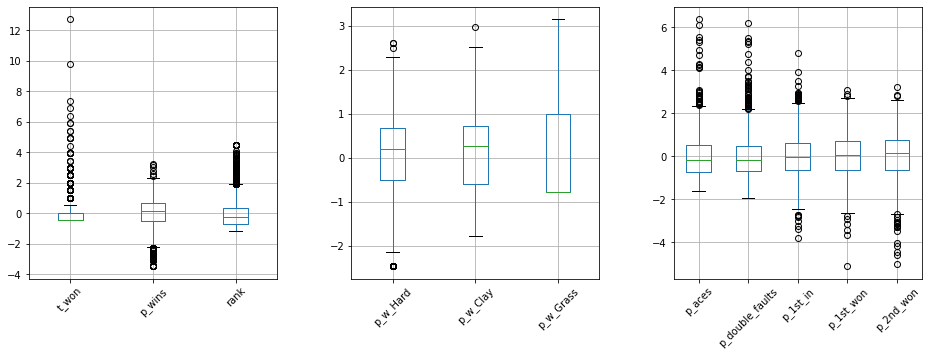

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
df_clusters_scaled[0].boxplot(list(df_clusters_scaled[0].columns), rot=45, ax=ax0)
df_clusters_scaled[1].boxplot(list(df_clusters_scaled[1].columns), rot=45, ax=ax1)
df_clusters_scaled[2].boxplot(list(df_clusters_scaled[2].columns), rot=45, ax=ax2)
fig.subplots_adjust(wspace=0.3)

## **K-means**

We run the k-means algorithm and we chose the best number of clusters based on the three indicators (the ones which we've seen during lesson), then we analize the results obtained.

### **Clustering on the first dataframe ["t_won", "p_wins", "rank"]**

**Indicators:**

*   **SSE Score** (Inertia): Sum of squared error
*   **Silhouette Score**: It combines both cohesion and separation. Cluster cohesion measures how closely related are objects in a cluster. Typically between 0 and 1, the closer to 1 the better.
*   **Davies Bouldin Score**: It is defined as a ratio of within cluster scatter and the between cluster separation. (Positive indicator, lower value closer to 0 is better).

In [8]:
def k_means(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

Calculate the SSE, Silhoutte and Davies-Bouldin score for each dataframe.

In [9]:
sse_clusters = list()
sil_clusters = list()
davies_clusters = list()
for i, x_cluster in enumerate(x_clusters):
    sse, sil, davies_bouldin = k_means(x_cluster, i, 20)
    sse_clusters.append(sse)
    sil_clusters.append(sil)
    davies_clusters.append(davies_bouldin)

Dataframe 0, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 1, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Dataframe 2, iterating over 20 possible K values:   0%|          | 0/19 [00:00<?, ?it/s]

Plot the indicators values for each k.

In [10]:
def plot_indicators(i_cluster, max_k, sse_list, sil_list, davies_list):

    # plot indicators
    fig, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Dataframe {0}, indicators".format(i_cluster), fontsize=22)

Let's focus on the first dataframe for now, the one with ["t_won", "p_wins", "rank"].

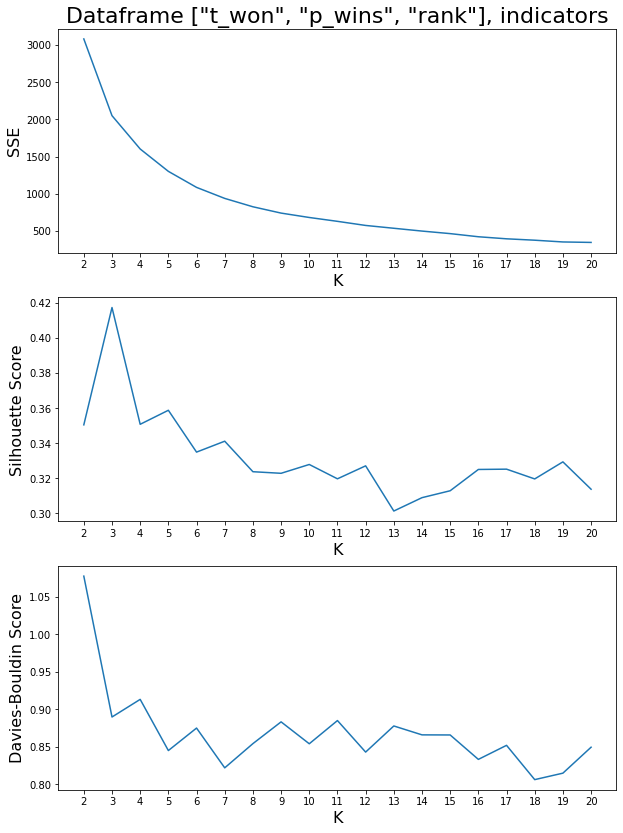

In [11]:
plot_indicators("[\"t_won\", \"p_wins\", \"rank\"]", 20, sse_clusters[0], sil_clusters[0], davies_clusters[0])

By using the elbow rule for the SSE graph and looking at the other two, we saw that the best value for k is 3, we proceed with our analysis.

In [12]:
k = 3  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[0])
print("SSE:", sse_clusters[0][k-2], " - SILHOUETTE:", sil_clusters[0][k-2])

SSE: 2050.1095317844583  - SILHOUETTE: 0.4174000719444161


Let's see how many players are in each cluster.

In [13]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 1011, 1: 375, 2: 214}


**Using Similarity Matrix for Cluster Validation**: if we have well-separated clusters, then the similarity matrix should be
roughly block-diagonal. The indices are sorted according to the labels of the clusters and the component $(i,j)$ of the *similarity matrix* is equal to $e^{-d(i,j)}$, where $d$ is the euclidean distance.

In [14]:
def plot_similarity_heatmap(df, labels):
    df_plot = pd.DataFrame(df, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]
    df_plot.sort_values(by='cluster', ascending=True, inplace=True)
    dist = euclidean_distances(df_plot.loc[:, columns], df_plot.loc[:, columns])
    sim = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(12,8))
    sn.heatmap(sim, ax=ax, cmap='coolwarm')

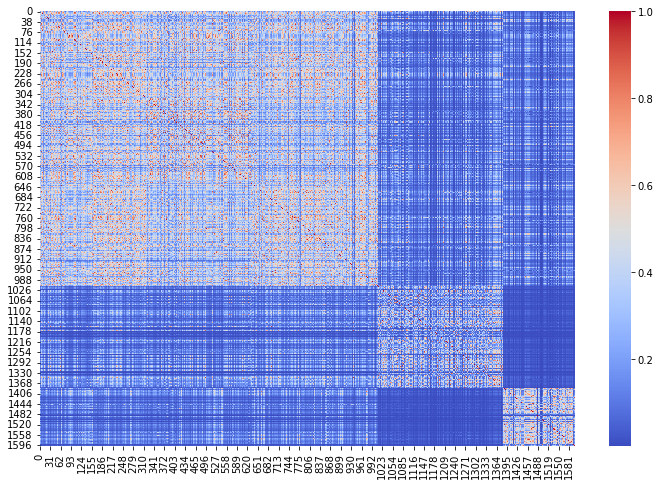

In [15]:
clusters_players = kmeans.labels_
plot_similarity_heatmap(df_clusters_scaled[0], clusters_players)

#### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Let's take the players with the most tourneys won.

In [16]:
df_players[df_players["t_won"]==df_players["t_won"].max()]

name sex  age  ioc  ...  rank_points age_range   ht_range  rank_range
255  novak djokovic   M   34  SRB  ...        12113   [28,34]  [181,190]      top 10

[1 rows x 32 columns]

We now plot the clusters using the PCA.

Text(255    6.630078
Name: PC_1, dtype: float64, 255    8.452943
Name: PC_2, dtype: float64, 'novak djokovic')

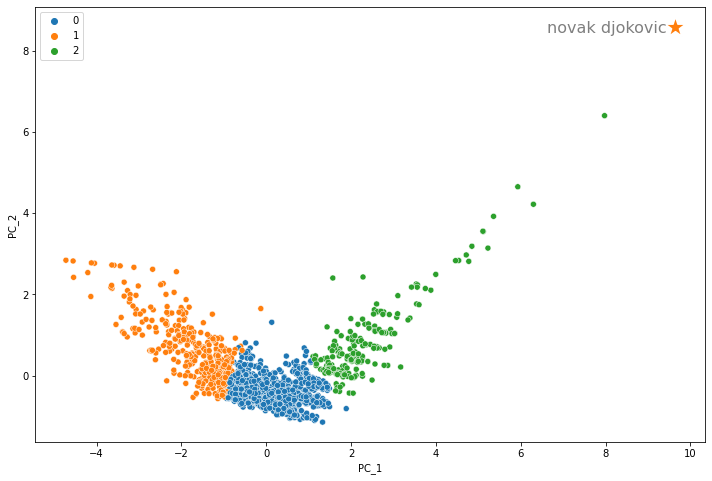

In [17]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[0]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

In [18]:
def plot_basic_statistics(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(14,8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i, columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)  
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        plt.plot(range(0, columns.shape[0]), means[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=55)

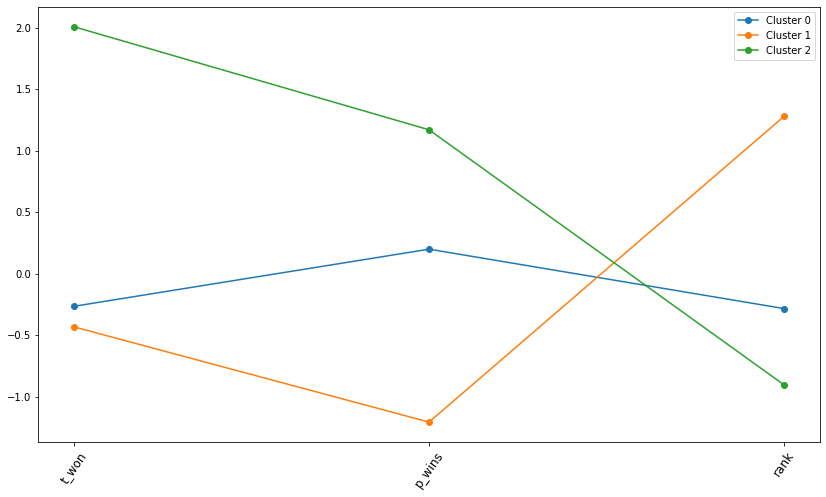

In [19]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[0], clusters_players, df_clusters_scaled[0].columns)

From what we can see the three clusters classify the players into different categories:
* a cluster that contains the best players.
* a cluster with players with an high percentage of wins but less tourneys won (those are probably players from the top25 to top100 in the rankings).
* a cluster that has all the remaining players.

In [20]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

t_won     p_wins        rank
cluster                                 
0        0.359050  46.913966  338.335312
1        0.016000  28.985307  952.824000
2        5.014019  59.291589   94.373832

In [21]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")
df_cluster_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   t_won    1600 non-null   float64
 1   p_wins   1600 non-null   float64
 2   rank     1600 non-null   float64
 3   cluster  1600 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 136.2 KB


The means we calculated for each cluster confirm our assumptions on the clustering.

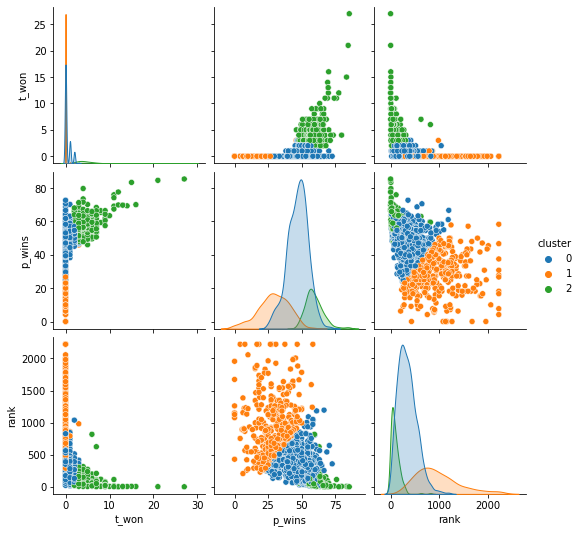

In [22]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

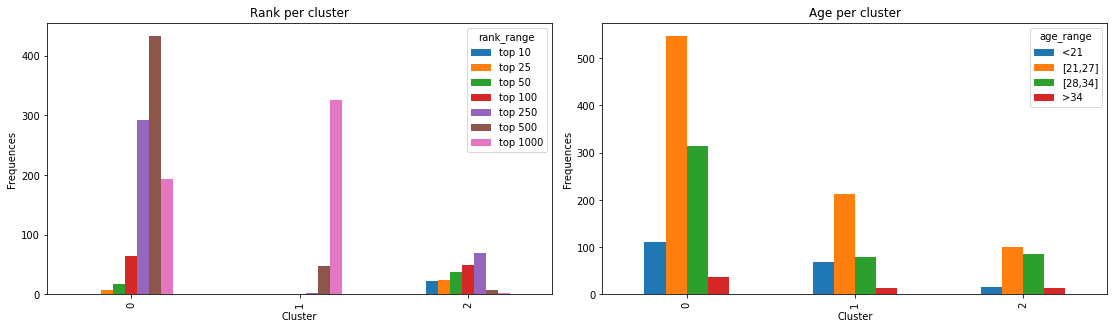

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

#### **Centroids analysis**

Let's analyze the dataframe by looking at the centroids.

In [24]:
centers = kmeans.cluster_centers_
df_centr = pd.DataFrame(centers, columns=df_clusters_scaled[0].columns)
df_centr

t_won    p_wins      rank
0 -0.264558  0.199552 -0.283248
1 -0.431945 -1.205382  1.279291
2  2.006766  1.169493 -0.903600

In [25]:
from math import pi
def plot_polar_centers(df, centers, columns):
    # number of variable
    N = len(columns)

    plt.figure(figsize = (8,8))
    label_s = 12

    for i in range(0,len(centers)):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = centers[i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        ax = plt.subplot(polar=True)
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], columns, color='grey', size=label_s) 
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid', label='Cluster %s' % i)
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)
        plt.legend()

The analysis above is better explained by the polar plot.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


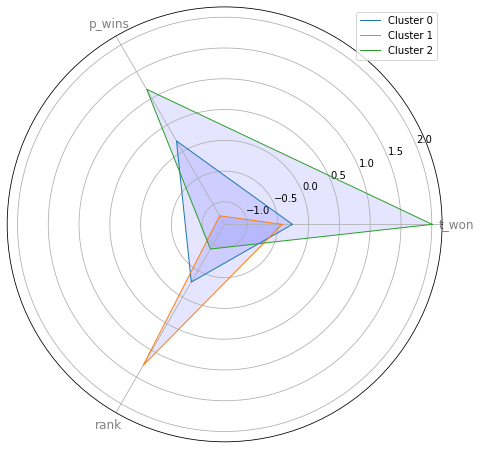

In [26]:
centers = kmeans.cluster_centers_
plot_polar_centers(df_clusters_scaled[0], centers, df_clusters_scaled[0].columns);

In [27]:
def plot_centers(x, centers, columns, labels):
    
    pca_to_visualize = PCA(n_components=2)
    data_to_visualize = pd.DataFrame(pca_to_visualize.fit_transform(x),columns=['PC_1','PC_2'])
    centers_to_visualize = pca_to_visualize.fit_transform(centers)
    
    plt.figure(figsize=(12,8))
    plt.scatter(data_to_visualize['PC_1'], data_to_visualize['PC_2'], c=labels, s=20)
    plt.scatter(centers_to_visualize[:, 0], centers_to_visualize[:, 1], s=100, marker='*', c='r')
    plt.xlabel('PC_1', fontsize=12)
    plt.ylabel('PC_1', fontsize=12)
    plt.show()

We show the position of the centroids in the plane given by the two first principal components.

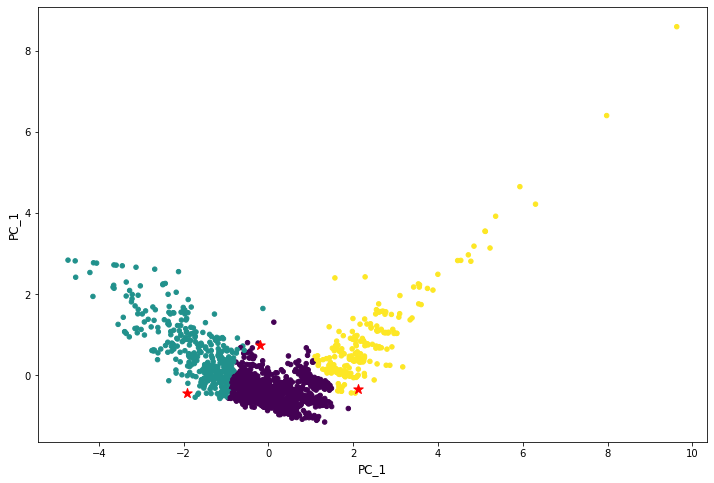

In [28]:
centers = kmeans.cluster_centers_
labels = kmeans.labels_
plot_centers(df_clusters_scaled[0].values, centers, df_clusters_scaled[0], labels)

We show the position of the centroids with respect to the **percentage of wins** and **rank** of the players

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


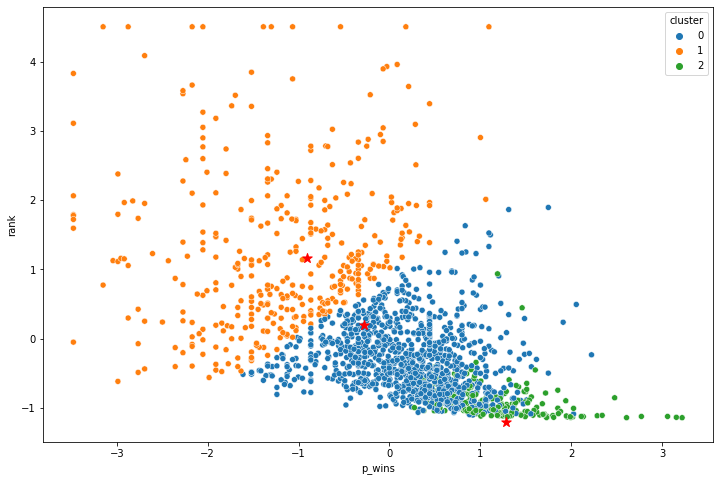

In [29]:
plt.figure(figsize=(12,8))
sn.scatterplot(df_clusters_scaled[0]["p_wins"], df_clusters_scaled[0]["rank"], hue=df_cluster_plot["cluster"], palette="tab10")
plt.scatter(centers[:, 2], centers[:, 1], s=100, marker='*', c="r")
plt.show()

### **Test k-kmeans with other features**

We still have to test k-means with the remaining three dataframes.

#### **Clustering on the second dataframe ["p_w_Hard", "p_w_Clay", "p_w_Grass"]**

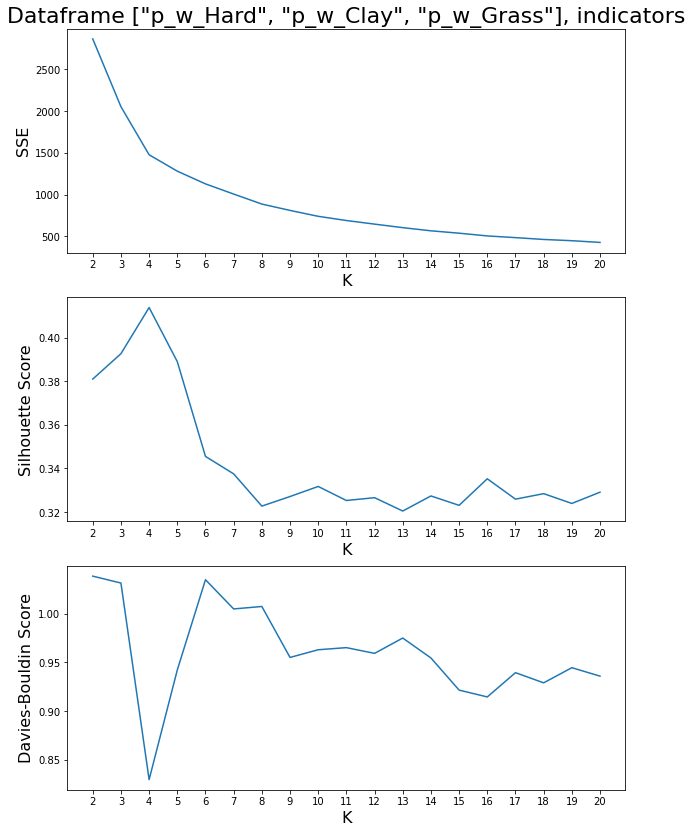

In [30]:
plot_indicators("[\"p_w_Hard\", \"p_w_Clay\", \"p_w_Grass\"]", 20, sse_clusters[1], sil_clusters[1], davies_clusters[1])  # ["p_w_Hard", "p_w_Clay", "p_w_Grass"]

By using the elbow rule on the SSE graph and by looking at the others we choose 4 as the best number of clusters.

In [31]:
k = 4  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[1])
print("SSE:",sse_clusters[1][k-2]," - SILHOUETTE:",sil_clusters[1][k-2])

SSE: 1477.8567063849637  - SILHOUETTE: 0.41381028649424495


##### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Text(255    3.29926
Name: PC_1, dtype: float64, 255   -0.286712
Name: PC_2, dtype: float64, 'novak djokovic')

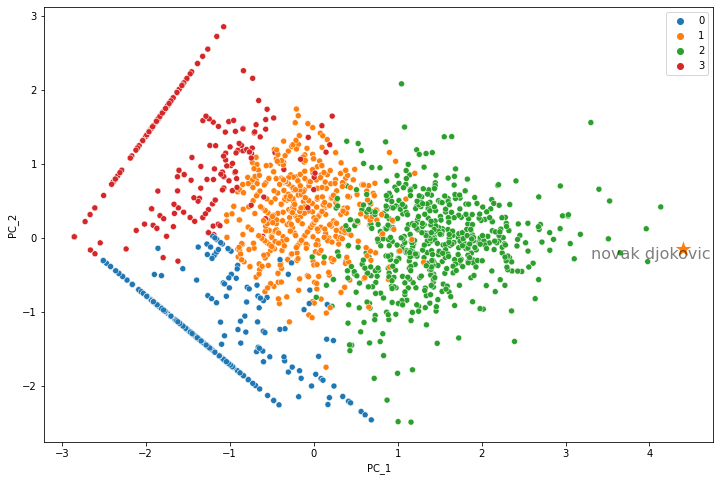

In [32]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[1]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-1.1, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

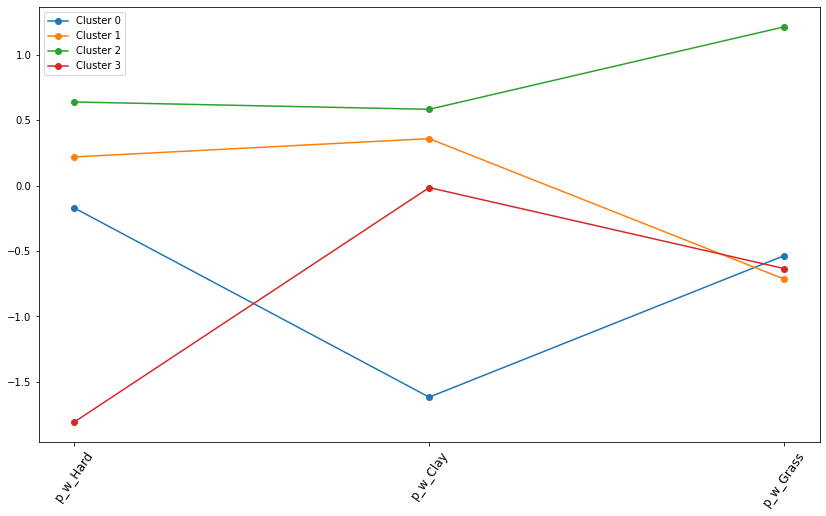

In [33]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[1], clusters_players, df_clusters_scaled[1].columns)

The only meaningful information is that we can see a cluster that contains those player called "all-rounder" (they perform well on each surface) and most of the best players fall within this cluster.

In [34]:
df_cluster_plot = df_clusters[1].copy()
df_cluster_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

p_w_Hard   p_w_Clay  p_w_Grass
cluster                                 
0        38.873839   3.390903   6.380645
1        45.445227  44.934477   1.820493
2        52.541964  49.648937  50.832450
3        11.215526  37.067149   3.864649

The means we calculated for each clusters confirm our assumptions on the clusters (i.e.: cluster 1 contains the best current players).

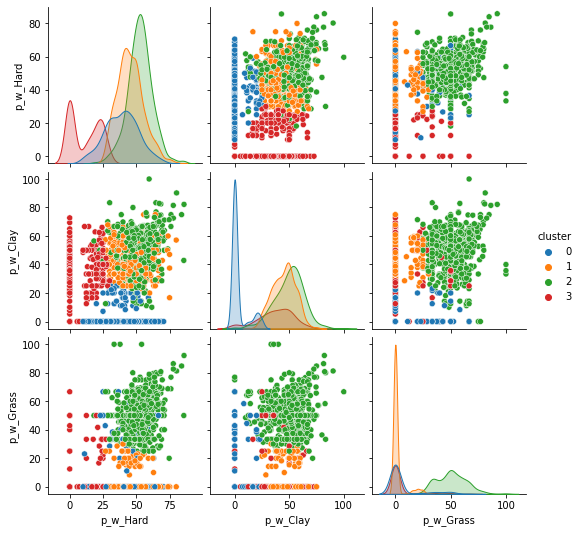

In [35]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

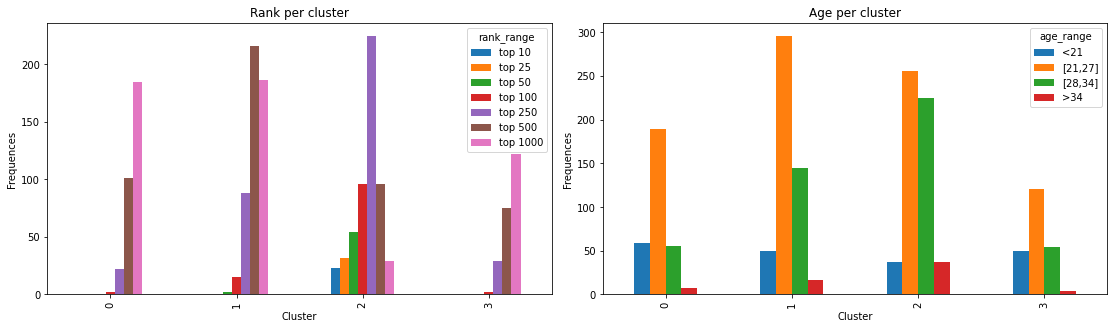

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

As expected the best players are in the "all-rounder" cluster, the other players are more or less distributed in the other clusters.

#### **Clustering on the third dataframe ["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won"]**

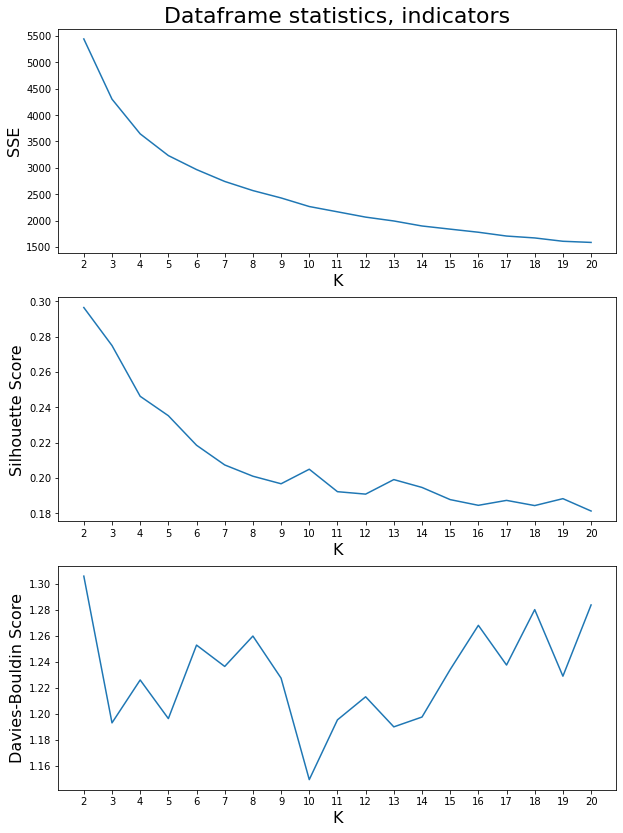

In [37]:
plot_indicators("statistics", 20, sse_clusters[2], sil_clusters[2], davies_clusters[2])  # ["p_aces", "p_double_faults", "p_1st_in", "p_1st_won", "p_2nd_won", "mean_sv_points"]

By using the elbow rule on the SSE graph and by looking at the others we choose 3 as the best number of clusters.

In [38]:
k = 3  # best k value
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_clusters[2])
print("SSE:",sse_clusters[2][k-2]," - SILHOUETTE:",sil_clusters[2][k-2])

SSE: 4302.6849543646895  - SILHOUETTE: 0.2749067188496095


##### **Cluster Visualization**

After calculating the indicators we can now visualize the clusters.

Text(255   -3.473006
Name: PC_1, dtype: float64, 255   -1.65676
Name: PC_2, dtype: float64, 'novak djokovic')

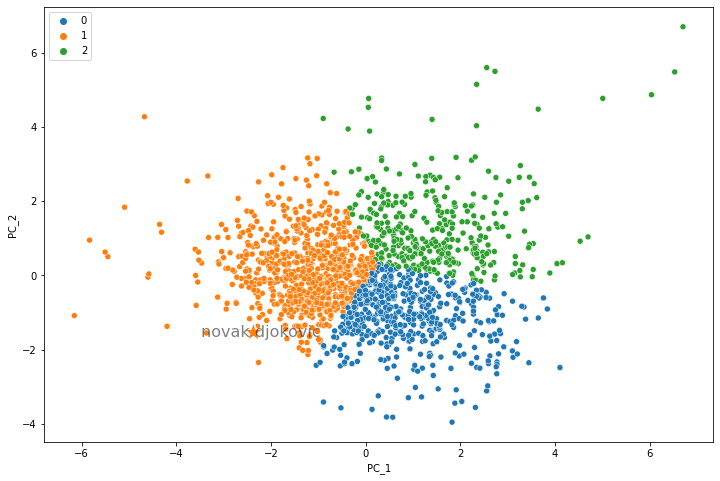

In [39]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[2]), columns=['PC_1','PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-1.1, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

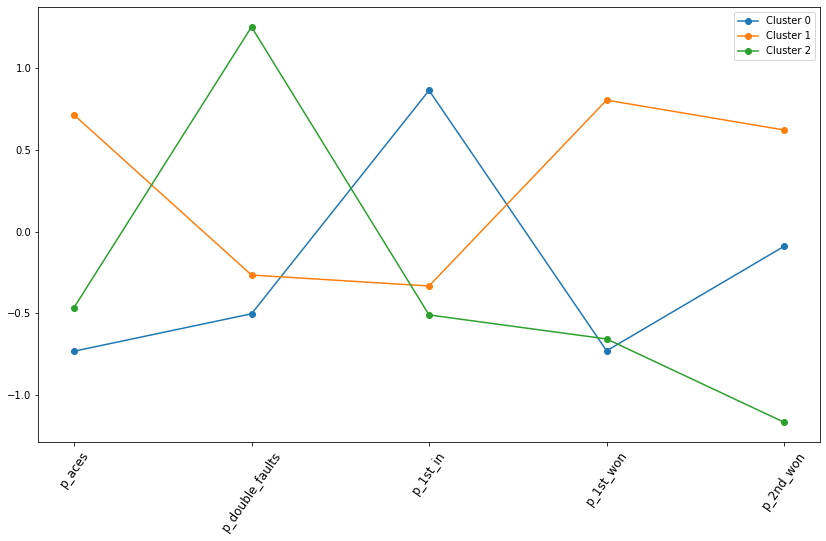

In [40]:
clusters_players = kmeans.labels_
plot_basic_statistics(df_clusters_scaled[2], clusters_players, df_clusters_scaled[2].columns)

The more left on the PCA analysis a player is, the more his/her playstyle is based on aces with an high percentage of success. Then there is a cluster formed by those players with a minimum risk approach on serves (hence the minimum double faults) meanwhile the last cluster is formed by those that take many risks while serving (hence the high number of double faults).

In [41]:
df_cluster_plot = df_clusters[2].copy()
df_cluster_plot["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

p_aces  p_double_faults   p_1st_in  p_1st_won  p_2nd_won
cluster                                                            
0        2.848032         3.916687  64.876526  62.192731  46.918675
1        7.274462         4.340457  59.606801  70.534449  49.682258
2        3.664050         7.054358  58.826620  62.587095  42.735782

It's not safe to assume that the best players belong to cluster 1, since they may have different playstyles between them.

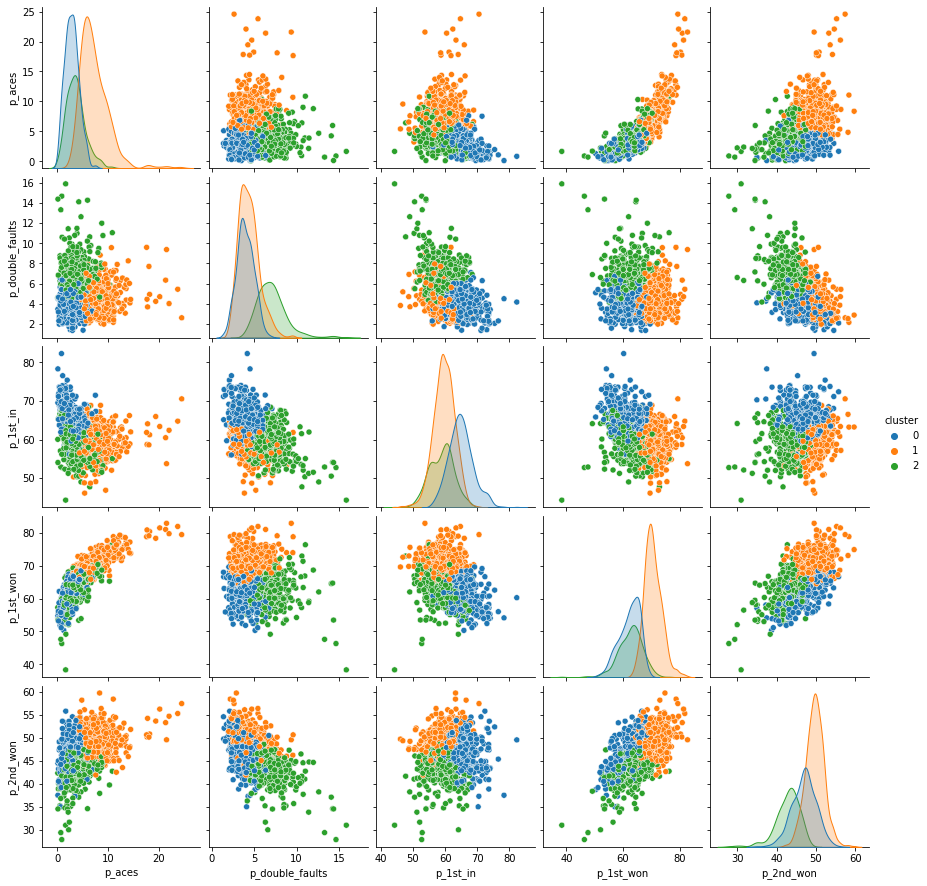

In [42]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

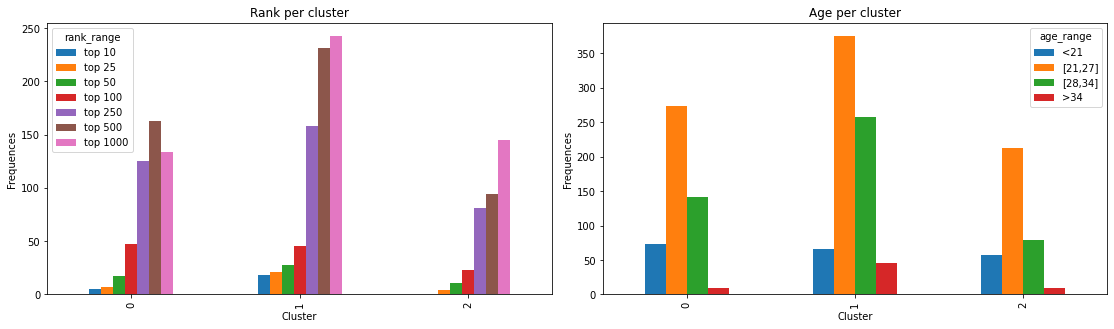

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(19, 5));

rank_xt_pct = pd.crosstab(kmeans.labels_, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', ax=axs[0], xlabel="Cluster", ylabel="Frequences")

age_xt_pct = pd.crosstab(kmeans.labels_, df_players['age_range'])
age_xt_pct.plot(kind='bar', stacked=False, title='Age per cluster', ax=axs[1], xlabel="Cluster", ylabel="Frequences")
fig.subplots_adjust(wspace=0.1)

It seems that the best players don't have a very aggressive playstyle while serving, still they are very efficient at doing aces.

## **DB-scan**
We now perform the DBSCAN clustering algorithm.

We decided to work only the first dataframe from the k-means analysis (the one with ["t_won", "p_wins", "rank"]) since we think better describes who are the best players and who aren't. To do this task we follow the same flow as in KMeans analysis.

In [44]:
df_clustering_dbscan = df_clusters[0].copy()
x_dbscan = scaler.fit_transform(df_clustering_dbscan.values)
df_clustering_dbscan_scaled = pd.DataFrame(x_dbscan, columns=df_clustering_dbscan.columns, index=df_players.index)

###**Grid search for min_samples and eps**

We choose the best hyperparameters for the dbscan by using the grid search on some possible values for both min_samples and eps. We want to underline the fact that what you see in this notebook is just the final range of which we tried the grid search, we pruned all the other values for the hyperparameters.

In [45]:
min_samples_grid = np.arange(2, 10)
eps_grid = np.round(np.linspace(0.2, 1, 17), 2)
print("Parameters for the grid search:\nmin_samples: {0}\neps: {1}".format(min_samples_grid, eps_grid))

Parameters for the grid search:
min_samples: [2 3 4 5 6 7 8 9]
eps: [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95 1.  ]


In [46]:
df_clusters_grid = pd.DataFrame(np.zeros((len(eps_grid), len(min_samples_grid))), index=eps_grid, columns=min_samples_grid)
df_sil_grid = pd.DataFrame(np.zeros((len(eps_grid), len(min_samples_grid))), index=eps_grid, columns=min_samples_grid)
for min_sample in tqdm(min_samples_grid):
    for eps in eps_grid:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(x_dbscan)
        df_clusters_grid.loc[eps, min_sample] = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))
        df_sil_grid.loc[eps, min_sample] = silhouette_score(x_dbscan, dbscan.labels_)

  0%|          | 0/8 [00:00<?, ?it/s]

Let's plot the results of the grid search, keep in mind that for the number of clusters the outliers are not counted.

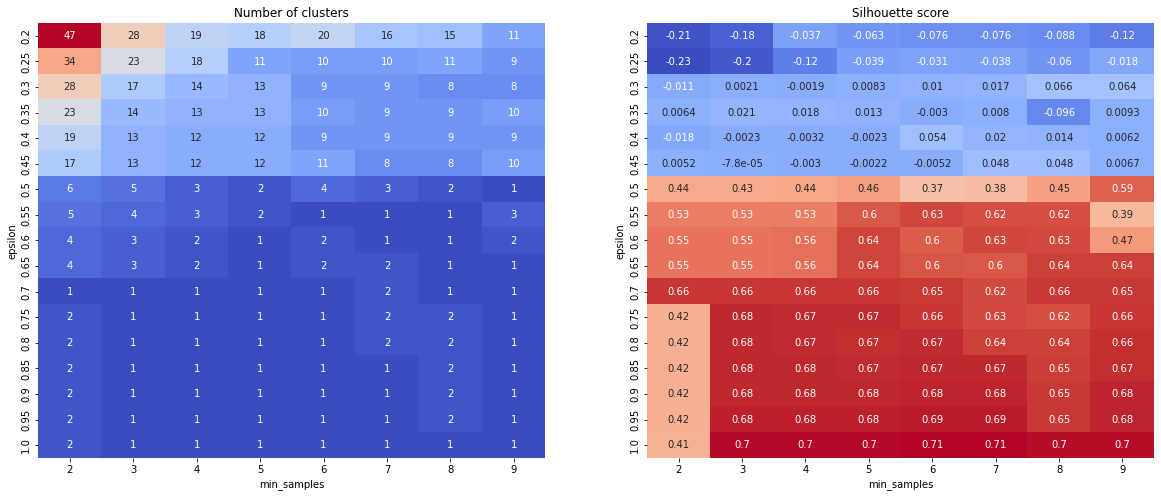

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sn.heatmap(df_clusters_grid, annot=True, ax=axs[0], cbar=False, cmap='coolwarm').set_title("Number of clusters")
sn.heatmap(df_sil_grid, annot=True, ax=axs[1], cbar=False, cmap='coolwarm').set_title("Silhouette score")
axs[0].set_xlabel("min_samples")
axs[0].set_ylabel("epsilon")
axs[1].set_xlabel("min_samples")
axs[1].set_ylabel("epsilon")
plt.show()

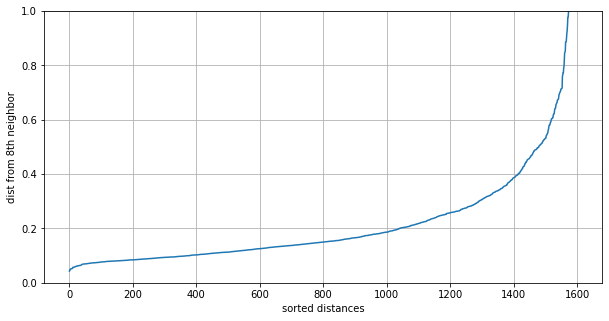

In [48]:
min_samples = 8  # min_samples
dist = pdist(x_dbscan, 'euclidean')  # pair wise distance
dist = squareform(dist)  # distance matrix given the vector dist
print()

kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[min_samples]
    kth_distances.append(d[index_kth_distance])
    
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % min_samples)
plt.xlabel('sorted distances')
plt.ylim(bottom = 0, top=1)
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()    

After trying some combinations of min_samples and eps we decided to take min_samples = 8 and eps= 0.55 and, as we can see with eps 0.55, the graph has the maximum curvature, so our choice was right.

###**Clustering**

Perform the dbscan algorithm.

In [49]:
eps = 0.55
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(x_dbscan)

DBSCAN(eps=0.55, min_samples=8)

In [50]:
print('Silhouette %s' % silhouette_score(x_dbscan, dbscan.labels_))

Silhouette 0.6208395505860075


Plot the clusters by using the PCA.

Text(255    6.530078
Name: PC_1, dtype: float64, 255    8.542943
Name: PC_2, dtype: float64, 'novak djokovic')

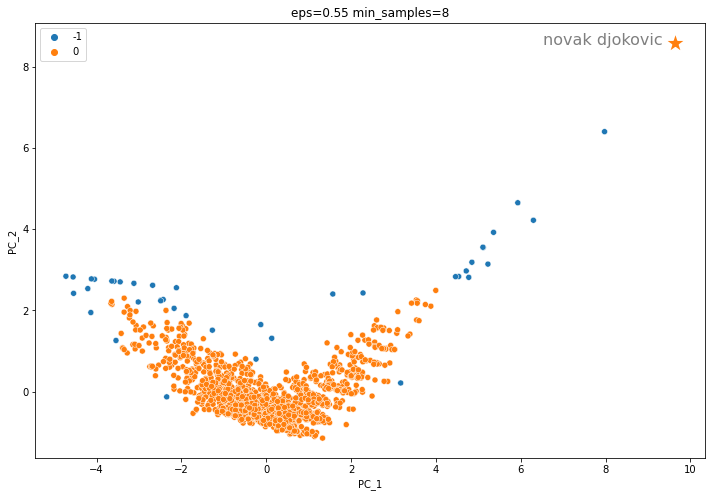

In [51]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_dbscan), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(dbscan.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title(label="eps=" + str(eps) + " min_samples=" + str(min_samples))

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

The outliers are those players who are extremely bad or good (so it takes the edges), or those that have won many minor tournaments. The big orange cluster is formed by the "normal" players.

In [52]:
df_cluster_plot = df_clustering_dbscan.copy()
df_cluster_plot["cluster"] = dbscan.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

t_won     p_wins         rank
cluster                                  
-1       4.976190  47.932143  1148.619048
 0       0.791399  44.271348   430.885751

In [53]:
index = df_cluster_plot[df_cluster_plot["cluster"]==-1].index
df_players.loc[index]

name sex  age  ... age_range   ht_range rank_range
0                 alexander zverev   M   24  ...   [21,27]       >190     top 10
19                     jan hernych   M   38  ...       >34  [181,190]   top 1000
26                 stephane robert   M   41  ...       >34  [181,190]   top 1000
52                   roger federer   M   39  ...       >34  [181,190]     top 10
61                 tomasz bednarek   M   36  ...       >34  [171,180]   top 1000
83                    jesse witten   M   35  ...   [28,34]  [171,180]   top 1000
101                    yen hsun lu   M   37  ...       >34  [171,180]   top 1000
205                   rafael nadal   M   35  ...   [28,34]  [181,190]     top 10
210                    damon gooch   M   31  ...   [28,34]  [181,190]   top 1000
251                    andy murray   M   34  ...   [28,34]  [181,190]    top 250
255                 novak djokovic   M   34  ...   [28,34]  [181,190]     top 10
446                 hsien yin peng   M   28  ...   [21,27]  [171,180]   top 1000
509                  gerald melzer   M   31  ...   [28,34]  [181,190]   top 1000
549                 jerzy janowicz   M   29  ...   [28,34]       >190   top 1000
594                   mark verryth   M   26  ...   [21,27]  [181,190]   top 1000
812                  dominic thiem   M   27  ...   [21,27]  [181,190]     top 10
912                daniil medvedev   M   25  ...   [21,27]       >190     top 10
932                gonzales austin   M   24  ...   [21,27]  [181,190]   top 1000
972                andrey yakovlev   M   27  ...   [21,27]       >190   top 1000
995           david vega hernandez   M   27  ...   [21,27]  [171,180]   top 1000
1268  ivar jose aramburu contreras   M   24  ...   [21,27]  [181,190]   top 1000
1577              daniele spinnato   M   28  ...   [21,27]  [181,190]   top 1000
1652               quentin gueydan   M   25  ...   [21,27]       >190   top 1000
1731                   logan smith   M   21  ...       <21  [181,190]   top 1000
1868                 artem strokan   M   25  ...   [21,27]  [181,190]   top 1000
1909             jackson j withrow   M   25  ...   [21,27]       >190   top 1000
1932              william blumberg   M   23  ...   [21,27]  [171,180]   top 1000
2037                enrico becuzzi   M   43  ...       >34  [181,190]   top 1000
2078              amal sultanbekov   M   19  ...       <21  [181,190]   top 1000
2349                   alex lawson   M   27  ...   [21,27]  [181,190]   top 1000
2981               serena williams   F   39  ...       >34  [171,180]     top 10
3050                 jessica moore   F   27  ...   [21,27]  [171,180]    top 500
3073                 petra kvitova   F   31  ...   [28,34]  [181,190]     top 10
3114                  simona halep   F   29  ...   [28,34]      <=170     top 25
3144             karolina pliskova   F   29  ...   [28,34]  [181,190]     top 10
3165                  darija jurak   F   36  ...       >34  [171,180]   top 1000
3200                ashleigh barty   F   25  ...   [21,27]      <=170     top 10
3223               elina svitolina   F   26  ...   [21,27]  [171,180]     top 10
3377           theiviya selvarajoo   F   23  ...   [21,27]      <=170   top 1000
3774               aryna sabalenka   F   23  ...   [21,27]  [181,190]     top 10
3788         nethmi himashi waduge   F   19  ...       <21  [171,180]   top 1000
4254                  david o hare   M   27  ...   [21,27]  [181,190]   top 1000

[42 rows x 32 columns]

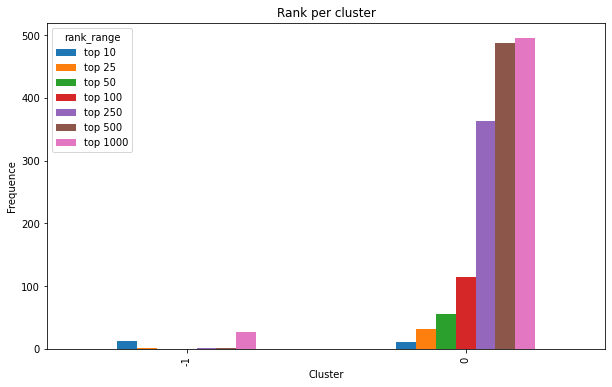

In [54]:
rank_xt_pct = pd.crosstab(dbscan.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

The graph tells us what we said before, the players consisdered as outliers are those at the edges of the rank.

## **Hierarchical**

As last algorithm we will use the hierarchical clustering with its differents methods.

In [55]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [56]:
df_clustering_hier = df_clusters[0].copy()
x_hier = scaler.fit_transform(df_clustering_hier.values)
df_clustering_hier_scaled = pd.DataFrame(x_hier, columns=df_clustering_hier.columns, index=df_players.index)

Method for plotting the graphs of the hierarchical clustering, taken from the scikit-learn official website.

In [57]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

###**Complete**

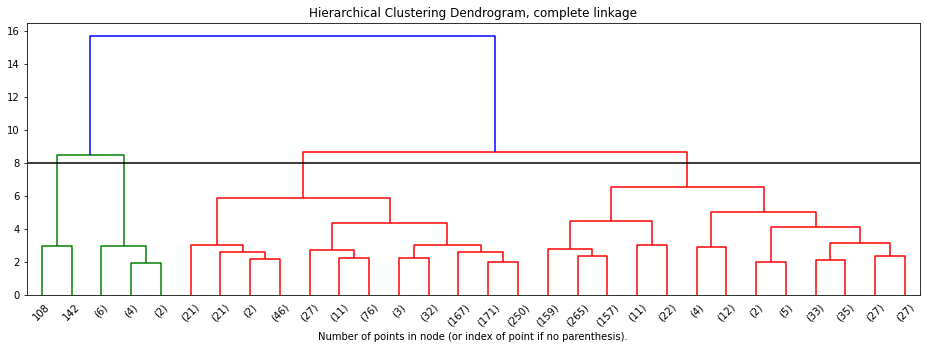

In [58]:
hier_complete = AgglomerativeClustering(distance_threshold=8, n_clusters=None, linkage="complete")
hier_complete = hier_complete.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, complete linkage")
plot_dendrogram(hier_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=8, color="black")

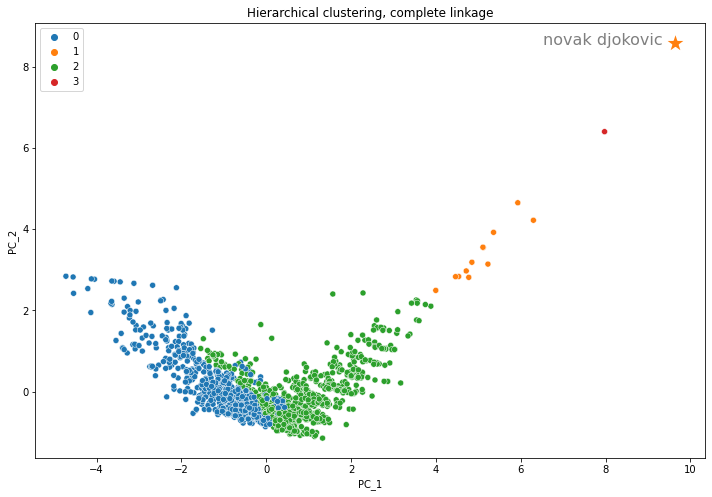

In [59]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_complete.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, complete linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

The information we can retrieve from the previous graph is that hierarchical clustering has separated the cluster with the best players seen in k-means in two clusters, one with the best players and the other with the two best players overall.

In [60]:
hist, bins = np.histogram(hier_complete.labels_, bins=range(0, len(set(hier_complete.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_complete.labels_))

{0: 759, 1: 12, 2: 827, 3: 2}
Silhouette 0.3082379849287149


In [61]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_complete.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

t_won     p_wins        rank
cluster                                  
0         0.050066  34.154084  642.932806
1        12.416667  71.683333   15.000000
2         1.459492  53.246276  279.796856
3        24.000000  85.045000    2.000000

Let's show the two overall best players.

In [62]:
index = df_cluster_plot[df_cluster_plot["cluster"]==3].index
df_players.loc[index]

name sex  age  ioc  ...  rank_points age_range   ht_range  rank_range
205    rafael nadal   M   35  ESP  ...         8270   [28,34]  [181,190]      top 10
255  novak djokovic   M   34  SRB  ...        12113   [28,34]  [181,190]      top 10

[2 rows x 32 columns]

In [63]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")

Plot the pairwise correlations between the considered features.

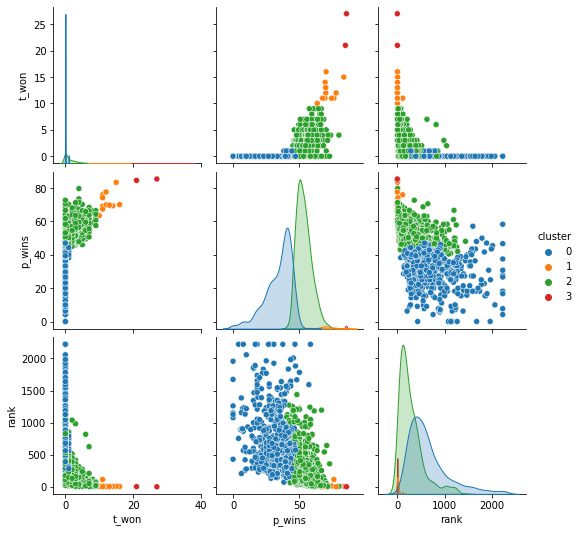

In [64]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

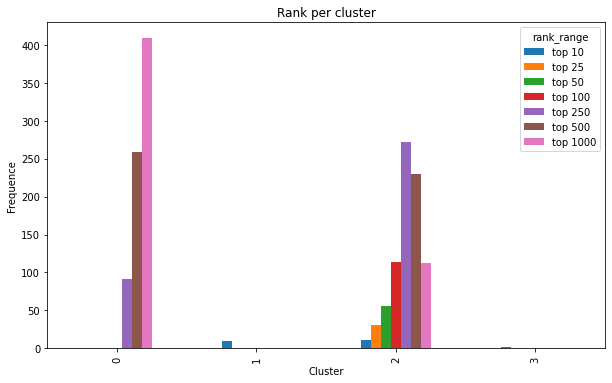

In [65]:
rank_xt_pct = pd.crosstab(hier_complete.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

As expected the the top 10 players are in the same cluster, meanwhile the extremely best players are in another one.

###**Single**

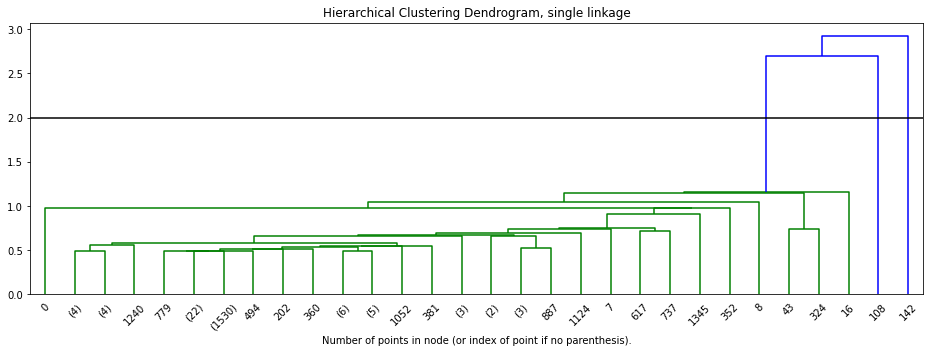

In [66]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_single = AgglomerativeClustering(distance_threshold=2, n_clusters=None, linkage="single")
hier_single = hier_single.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, single linkage")
plot_dendrogram(hier_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=2, color="black")

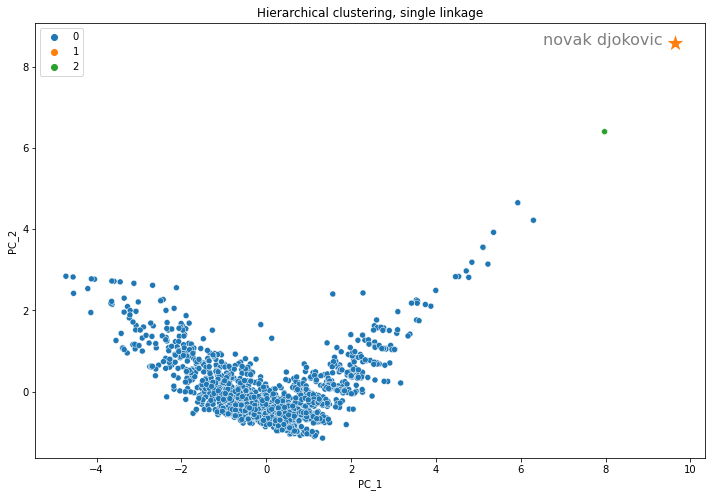

In [67]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_single.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, single linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

This time the clustering is extremely underwhelming, we have three cluster and two of them consist of just one player each, albeit those players are the two best overall as we've seen in the complete linkage method.

In [68]:
hist, bins = np.histogram(hier_single.labels_, bins=range(0, len(set(hier_single.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_single.labels_))

{0: 1598, 1: 1, 2: 1}
Silhouette 0.8012613600098762


In [69]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_single.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

t_won     p_wins        rank
cluster                                 
0         0.87234  44.316533  450.286608
1        27.00000  85.450000    1.000000
2        21.00000  84.640000    3.000000

In [70]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")

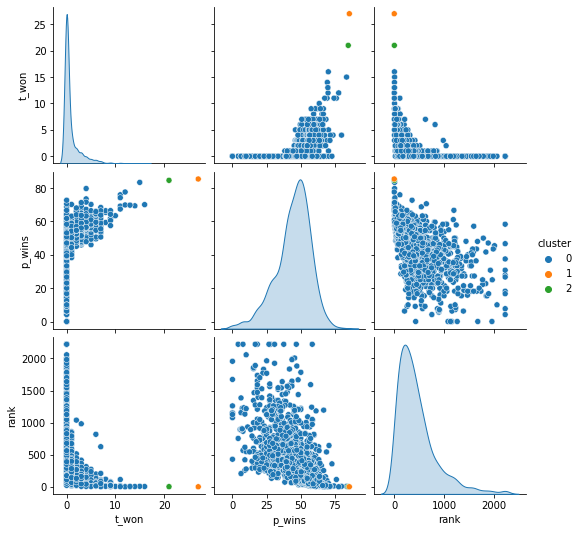

In [71]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

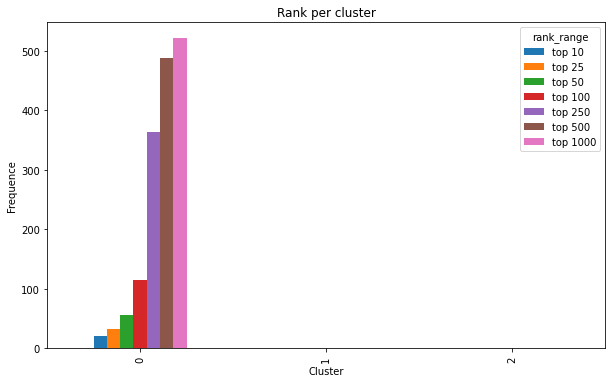

In [72]:
rank_xt_pct = pd.crosstab(hier_single.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

###**Average**

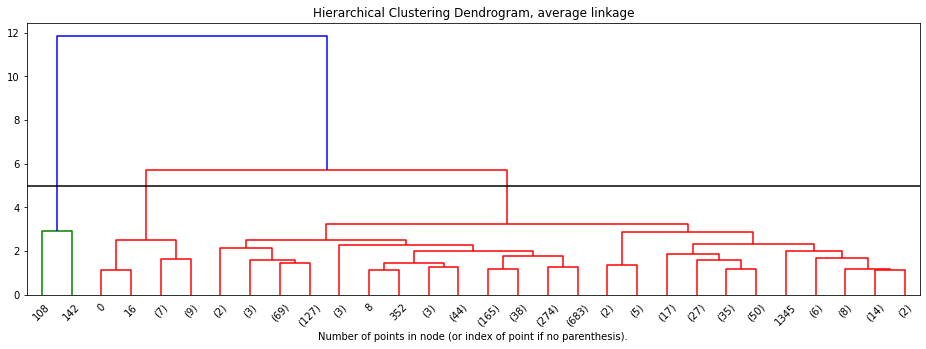

In [73]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_average = AgglomerativeClustering(distance_threshold=5, n_clusters=None, linkage="average")
hier_average = hier_average.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, average linkage")
plot_dendrogram(hier_average, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=5, color="black")

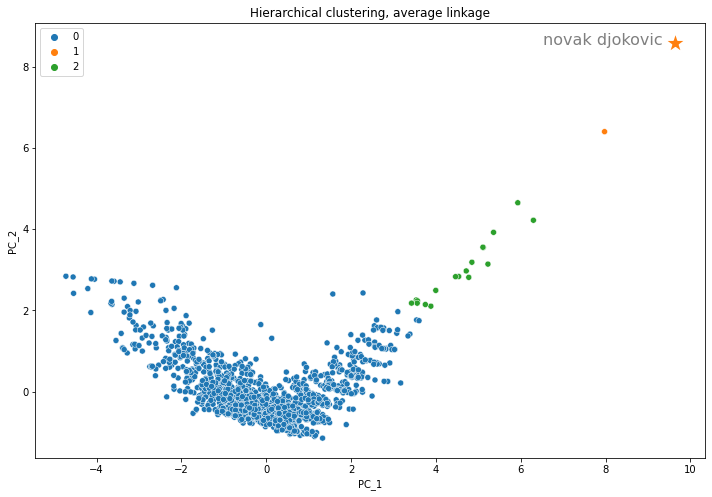

In [74]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_average.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, average linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

In [75]:
hist, bins = np.histogram(hier_average.labels_, bins=range(0, len(set(hier_average.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_average.labels_))

{0: 1580, 1: 2, 2: 18}
Silhouette 0.6484604763817379


In [76]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_complete.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

t_won     p_wins        rank
cluster                                  
0         0.050066  34.154084  642.932806
1        12.416667  71.683333   15.000000
2         1.459492  53.246276  279.796856
3        24.000000  85.045000    2.000000

The average linkage gives similar results to the complete one, there's no point in showing everyhitng again.

###**Ward**

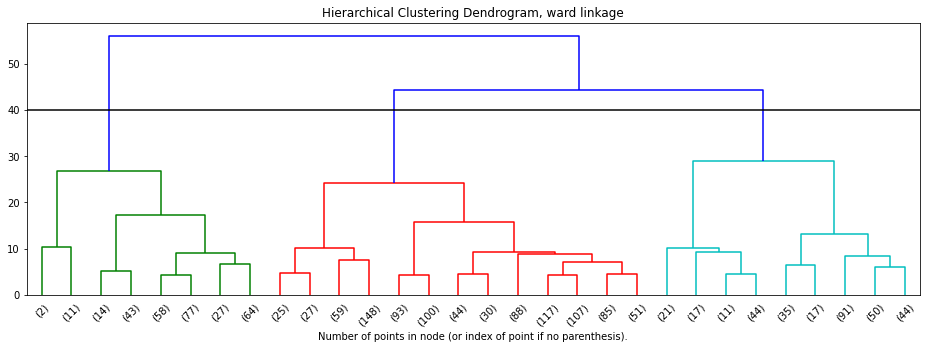

In [77]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_ward = AgglomerativeClustering(distance_threshold=40, n_clusters=None, linkage="ward")
hier_ward = hier_ward.fit(x_hier)

plt.figure(figsize=(16, 5))
plt.title("Hierarchical Clustering Dendrogram, ward linkage")
plot_dendrogram(hier_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=40, color="black")

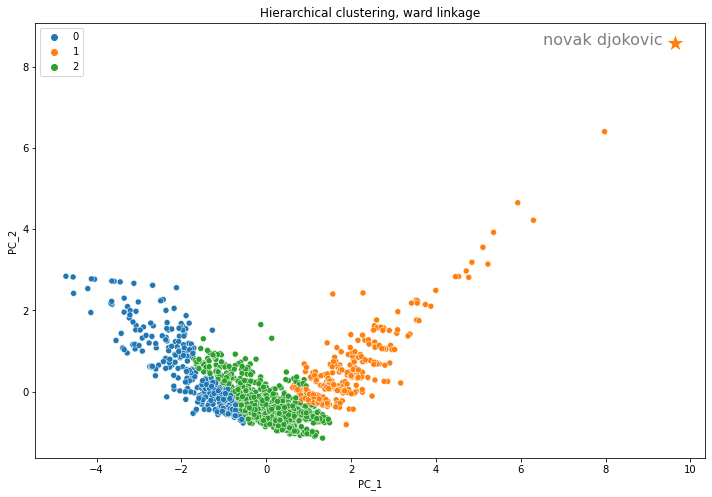

In [78]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_hier), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(hier_ward.labels_)
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)
plt.title("Hierarchical clustering, ward linkage")

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_players[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3.1, y=b-0.05, s=name, fontdict=dict(color='black', alpha=0.5, size=16));

This scatterplot highlights three different clusters, giving us almost the same result we obtained running K-Means

In [79]:
hist, bins = np.histogram(hier_ward.labels_, bins=range(0, len(set(hier_ward.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)
print('Silhouette %s' % silhouette_score(x_hier, hier_ward.labels_))

{0: 330, 1: 296, 2: 974}
Silhouette 0.3755751046876972


In [80]:
df_cluster_plot = df_clusters[0].copy()
df_cluster_plot["cluster"] = hier_ward.labels_  # insert the column "cluster"
df_cluster_plot.groupby("cluster").mean()

t_won     p_wins        rank
cluster                                 
0        0.000000  25.773212  857.136364
1        4.195946  57.207804  113.030405
2        0.205339  46.765133  414.014374

In [81]:
df_cluster_plot["t_won"] = np.floor(df_cluster_plot["t_won"]).astype("float64")
df_cluster_plot["rank"] = np.floor(df_cluster_plot["rank"]).astype("float64")

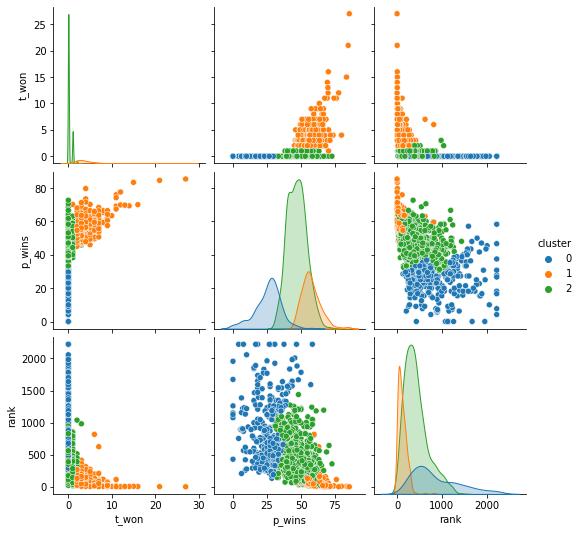

In [82]:
sn.pairplot(df_cluster_plot, hue='cluster', palette='tab10')
plt.show()

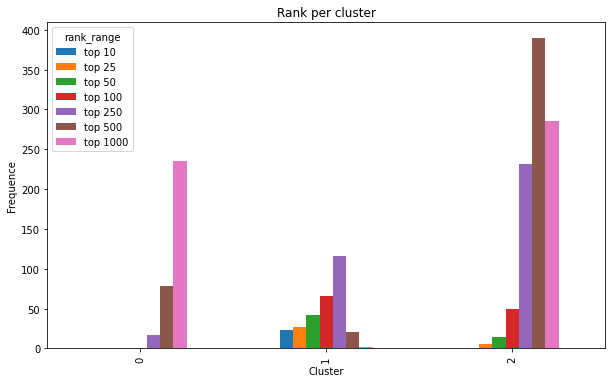

In [83]:
rank_xt_pct = pd.crosstab(hier_ward.labels_, df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(10, 6), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

## **Validation by external measures**

We compute the **cross-correlation** between the **similarity matrix** of the clustering and the **incidence matrix** (where the component $(i, j)$ is equal to $1$ if $i$ and $j$ are in the same cluster, $0$ otherwise). The *incidence matrix* represents the similarity matrix of a perfect clustering

In [84]:
def plot_cross_correlation(df_scaled, cluster_method):
    """ Plot cross correlation between the distance matrix and the incidence matrix
    """  
    scaler = StandardScaler()

    labels = cluster_method.labels_
    df = pd.DataFrame(df_scaled, copy=True)
    df['cluster'] = labels
    columns = df.columns[0:-1]
    df.sort_values(by='cluster', ascending=True, inplace=True)
    dist_matrix = euclidean_distances(df.loc[:, columns], df.loc[:, columns])
    sim_matrix = np.exp(-dist_matrix)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 
    
    # visualize similarity matrix
    df_sim = pd.DataFrame(sim_matrix)  
    sn.heatmap(df_sim, cmap='coolwarm', ax=ax1)
    
    labels.sort()
    n = len(labels)
    inc_matrix = []
    for i in range(n):
        row = []
        for j in range(n):
            if labels[i] == labels[j]: # check the cluster affiliation
                row.append(1) # assign 1 if records belongs to the same cluster, 0 otherwise
            else:
                row.append(0)
        inc_matrix.append(row)
    
    # visualize incidence matrix
    df_inc = pd.DataFrame(inc_matrix)
    sn.heatmap(df_inc, cmap='coolwarm', ax=ax2)


    sim_matrix_scaled = scaler.fit_transform(sim_matrix)
    inc_matrix_scaled = scaler.fit_transform(inc_matrix)
    corr_matrix = np.corrcoef(sim_matrix_scaled, inc_matrix_scaled)
    df_corr = pd.DataFrame(corr_matrix)
    
    # visualize cross-correlation
    plt.figure(figsize=(9, 6))
    sn.heatmap(df_corr, cmap='coolwarm')

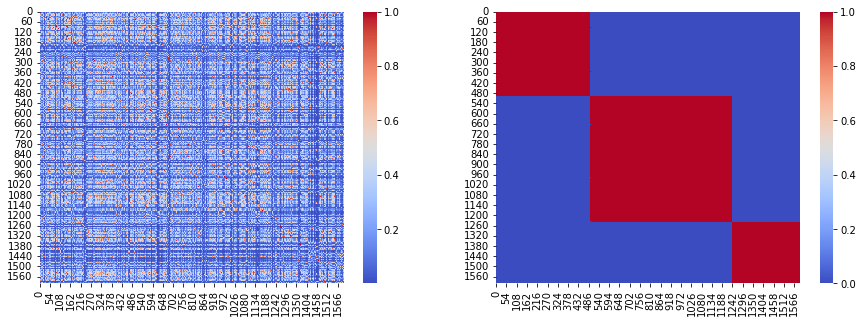

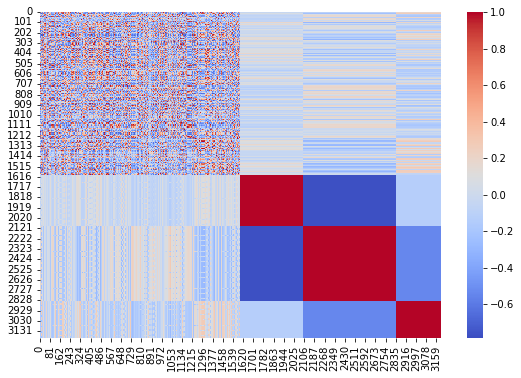

In [85]:
plot_cross_correlation(df_clusters_scaled[0], kmeans)

We compute the **entropy** of each feature per cluster

In [86]:
def entropy(data):
    """ Calculates entropy of the passed pd.Series
    """

    p_data = data.value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data)  # get entropy from counts

    return entropy

In [87]:
def entropy_clusters(df_scaled, cluster_method, columns):
    """ Calculates entropy of features per cluster
    """
  
    labels = cluster_method.labels_
    #centers = cluster_method.cluster_centers_
    df = pd.DataFrame(df_scaled, columns=columns, copy=True)
    df['cluster'] = labels
    
    df_entropy = pd.DataFrame(index=range((max(labels)-min(labels))+1), columns=columns)
    for i in range(min(labels), max(labels)+1):
        df_cluster = df[df['cluster']==i]
        df_cluster = df_cluster.iloc[:,:-1]
        ent = df_cluster.apply(entropy, axis=0)
        df_entropy.at[i,:] = ent

    df_entropy['total'] = df_entropy.sum(axis=1)
    df_entropy['cluster'] = range(min(labels), max(labels)+1)

    return df_entropy

In [88]:
df_clustering_dbscan_scaled

t_won    p_wins      rank
0     7.367218  2.014899 -1.130862
8    -0.439752  0.084832  1.012741
13   -0.439752  0.619264 -0.276472
14   -0.439752 -1.125868 -0.512955
15   -0.439752 -0.519343  0.768630
...        ...       ...       ...
4253 -0.439752  0.685872  0.961885
4254 -0.439752 -1.386815  4.504044
4255 -0.439752  0.210995  0.313464
4256 -0.439752 -0.261530  0.285493
4257 -0.439752 -0.390045 -0.151874

[1600 rows x 3 columns]

In [89]:
df_entropy = entropy_clusters(df_clustering_hier_scaled, hier_ward, df_clustering_hier_scaled.columns)
df_entropy

t_won   p_wins     rank      total  cluster
0         0  4.13727  5.58255   9.719820        0
1   1.96056  5.59961   5.1522  12.712367        1
2  0.540751  5.75186  6.28134  12.573955        2

In [90]:
#df_entropy_dbscan = entropy_clusters(df_clusters_scaled[2], dbscan, df_clusters_scaled[2].columns)
#df_entropy_dbscan

##**Other clusterings**

We explore two more clustering approaches by using the pyclustering library.

Install and import the needed package.

In [91]:
!pip install pyclustering
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.somsc import somsc
from pyclustering.cluster import cluster_visualizer

     |████████████████████████████████| 2.6 MB 26.3 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=1546516b195e0f2ac5061076348b509defe8f1fdc4995f4164f0a1c51d536e5c
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


###**x-means clustering**

From the pyclustering package documentation: X-means clustering method starts with the assumption of having a minimum number of clusters, and then dynamically increases them. X-means uses specified splitting criterion to control the process of splitting clusters.

In [92]:
# initialize centroids
initial_centers = kmeans_plusplus_initializer(df_clusters_scaled[0], 3, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()

# create instance of x-means algorithm
xmeans_instance = xmeans(df_clusters_scaled[0], initial_centers)

# x-means processing and results
xmeans_instance.process()
xmeans_clusters = xmeans_instance.get_clusters()
xmeans_centers = xmeans_instance.get_centers()

As always we assign to each player (actually the dataframe with their features scaled) the cluster to which they belong to.

In [93]:
xmeans_clusters_plot = pd.DataFrame(np.zeros((len(df_players), 1)), columns=["cluster"])
df_plot_xmeans = df_clusters[0].copy()
for i, cluster in enumerate(xmeans_clusters):
    xmeans_clusters_plot.loc[cluster] = i

df_plot_xmeans["cluster"] = list(xmeans_clusters_plot["cluster"])

In [94]:
df_plot_xmeans.groupby("cluster").mean()

t_won     p_wins         rank
cluster                                   
0.0       0.073034  43.589326   872.505618
1.0       0.074935  41.666615   391.785530
2.0       0.000000  26.524375   453.761364
3.0       0.000000  18.156875  1028.575000
4.0       0.000000  31.337937  1711.968254
5.0       2.734597  55.036161   142.199052
6.0       6.024691  59.403580    86.728395
7.0      12.416667  71.683333    15.000000
8.0      24.000000  85.045000     2.000000
9.0       0.336585  52.571439   257.121951

In [95]:
df_plot_xmeans["t_won"] = np.floor(df_plot_xmeans["t_won"]).astype("float64")
df_plot_xmeans["rank"] = np.floor(df_plot_xmeans["rank"]).astype("float64")

Plot the clusters by using the PCA and the correlations between the features.

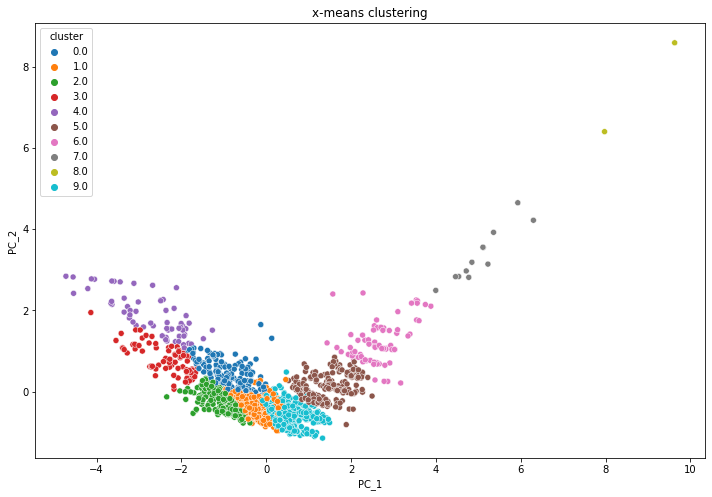

In [96]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[0]), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(df_plot_xmeans["cluster"])
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize, palette="tab10")
plt.title("x-means clustering");

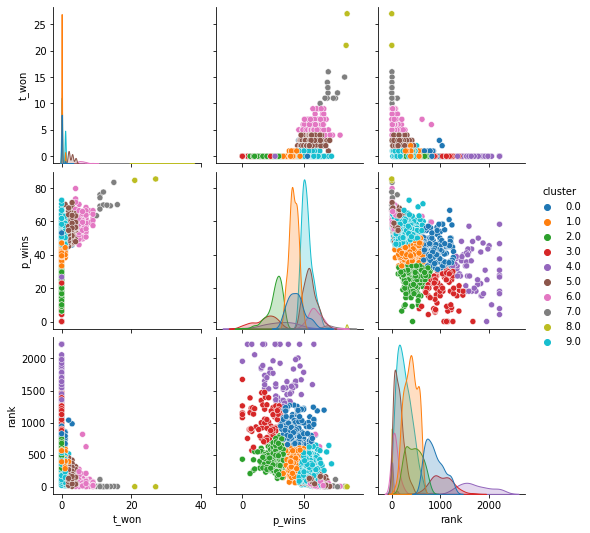

In [97]:
sn.pairplot(df_plot_xmeans, hue="cluster", palette="tab10")
plt.show()

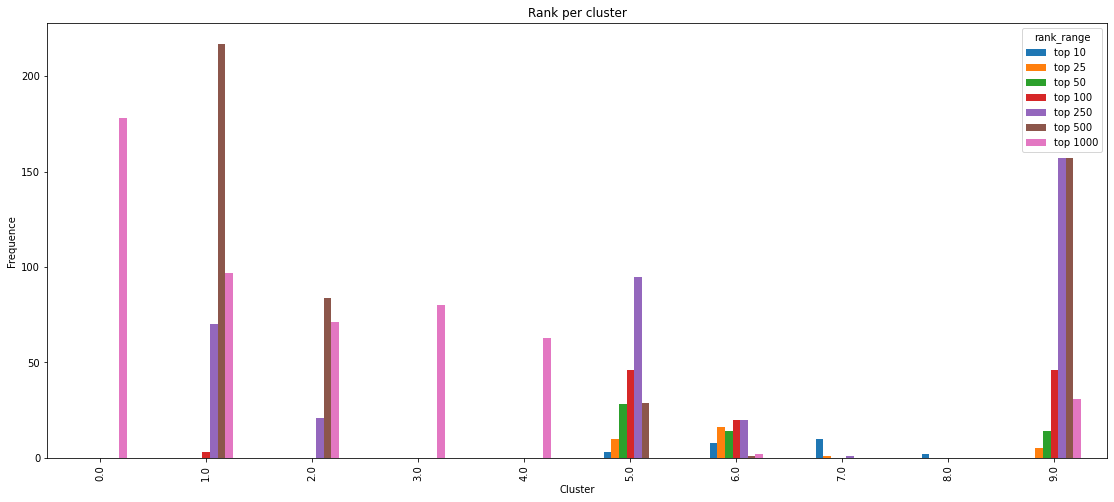

In [98]:
rank_xt_pct = pd.crosstab(df_plot_xmeans["cluster"], df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(19, 8), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

It seems without a doubt that x-means is a lot better than our previous attempts. Even though it creates a lot of clusters we don't need to define their number and this could lead to different results between each run.

The clustering done by x-means on our dataframe divides the players even more based on their actual abiltiies defining very clear levels of strength.

###**SOM soft-clustering**

From the pyclustering package documentation: this algorithm uses an amount of clusters that should be allocated as the size of a SOM map. The captured objects by the neurons are clusters.

Let's look for the best number of clusters.

In [99]:
sse_somsc = list()
sil_somsc = list()
davies_somsc = list()
df_somsc_clusters = pd.DataFrame(np.zeros((len(df_players), 1)), columns=["cluster"])
for k in tqdm(range(2, 21)):
    somsc_instance = somsc(list(df_clusters_scaled[0].values), k)
    somsc_instance.process()
    somsc_clusters = somsc_instance.get_clusters()
    for i, cluster in enumerate(somsc_clusters):
        df_somsc_clusters.loc[cluster] = i
    
    davies_somsc.append(davies_bouldin_score(x_clusters[0], df_somsc_clusters["cluster"]))
    sil_somsc.append(silhouette_score(x_clusters[0], df_somsc_clusters["cluster"]))
    # sse = kmeans_iter.inertia_
    # sse_somsc.append(sse)

  0%|          | 0/19 [00:00<?, ?it/s]

We can plot the results for each value of k to choose the best one, we want to undeline the fact that we couldn't retrieve any information about the SSE for the SOM approach since the library doesn't have any method to obtain the centroids.

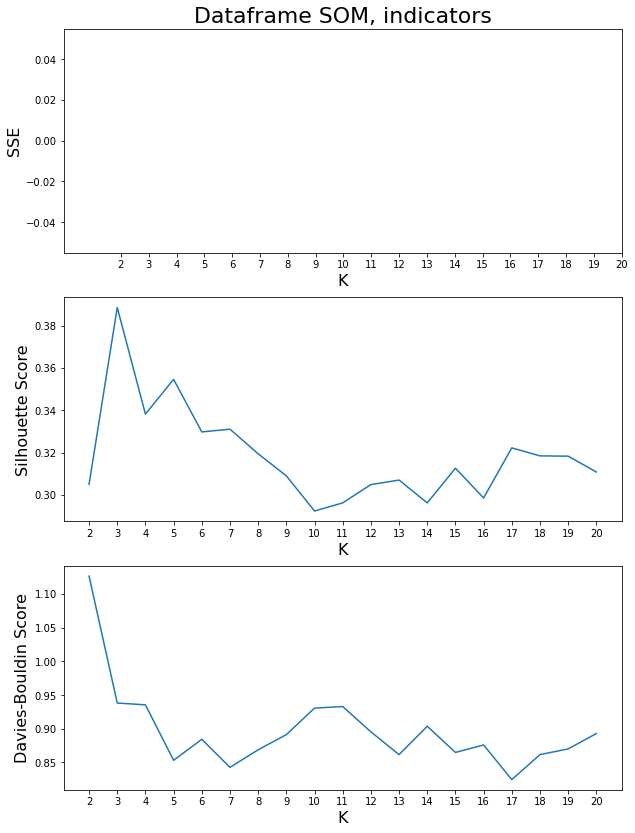

In [100]:
plot_indicators("SOM", 20, sse_somsc, sil_somsc, davies_somsc)

As we can see from the graphs it seems that k=3 is the best choice given the fact that it's tradeoff between the silhoutte score and the Davies-Bouldin score.

Let's do the clustering with k=3.

In [101]:
# create instance of somsc algorithm
somsc_instance = somsc(list(df_clusters_scaled[0].values), 3)

# x-means processing and results
somsc_instance.process()
somsc_clusters = somsc_instance.get_clusters()

As always we assign to each player (actually the dataframe with their features scaled) the cluster to which they belong to.

In [102]:
somsc_clusters_plot = pd.DataFrame(np.zeros((len(df_players), 1)), columns=["cluster"])
df_plot_somsc = df_clusters[0].copy()
for i, cluster in enumerate(somsc_clusters):
    somsc_clusters_plot.loc[cluster] = i

df_plot_somsc["cluster"] = list(somsc_clusters_plot["cluster"])

In [103]:
df_plot_somsc.groupby("cluster").mean()

t_won     p_wins        rank
cluster                                 
0.0      5.024038  59.613990   91.682692
1.0      0.008021  28.514947  908.871658
2.0      0.387033  47.076238  354.198428

In [104]:
df_plot_somsc["t_won"] = np.floor(df_plot_xmeans["t_won"]).astype("float64")
df_plot_somsc["rank"] = np.floor(df_plot_xmeans["rank"]).astype("float64")

Plot the clusters by using the PCA and the correlations between the features.

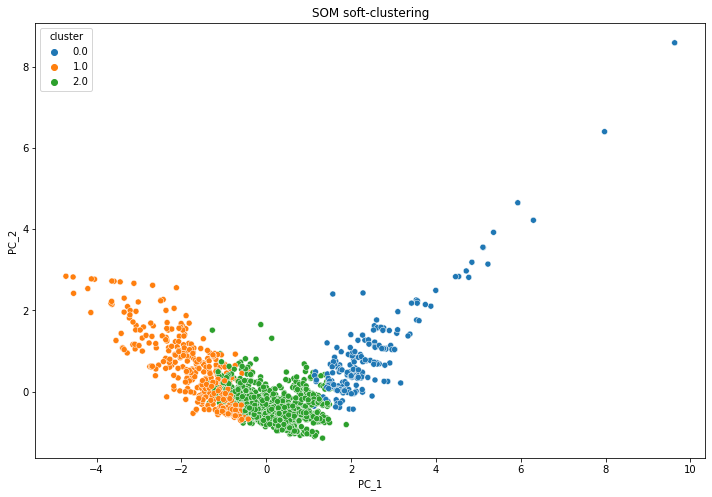

In [105]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(x_clusters[0]), columns=['PC_1', 'PC_2'], index=df_players.index)
data_to_visualize['cluster'] = pd.Categorical(df_plot_somsc["cluster"])
plt.figure(figsize=(12, 8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize, palette="tab10")
plt.title("SOM soft-clustering");

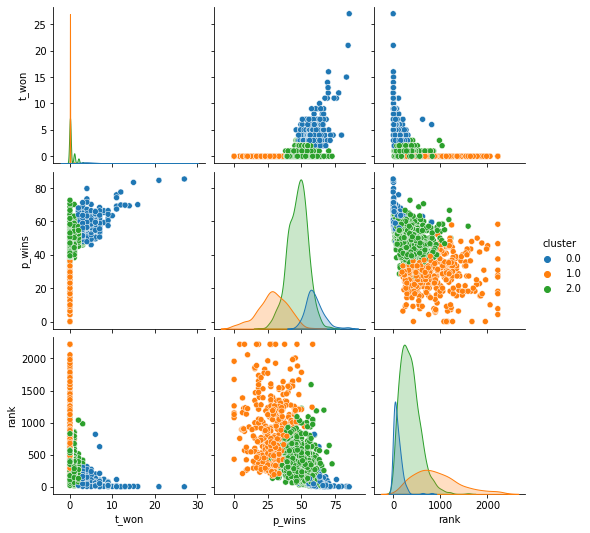

In [106]:
sn.pairplot(df_plot_somsc, hue="cluster", palette="tab10")
plt.show()

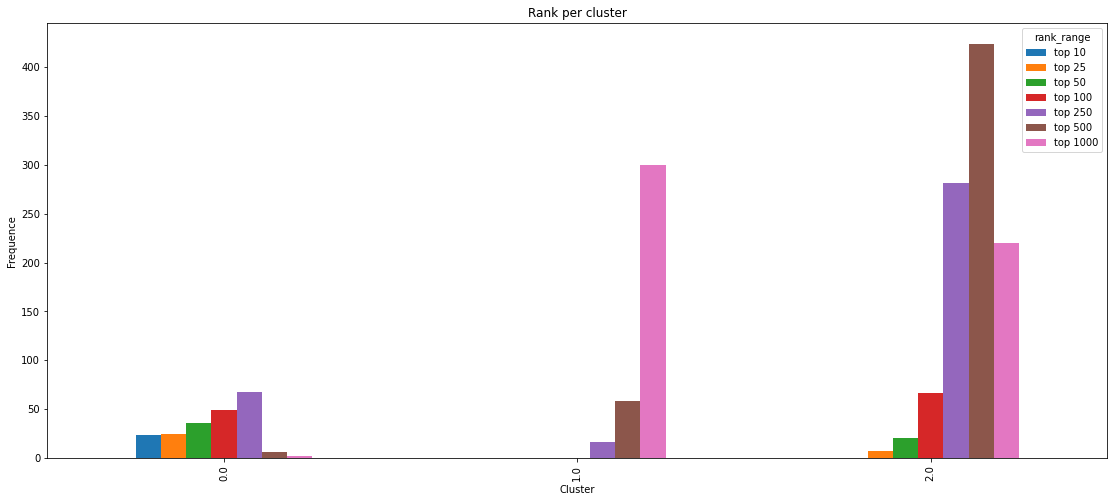

In [107]:
rank_xt_pct = pd.crosstab(df_plot_somsc["cluster"], df_players['rank_range'])

rank_xt_pct.plot(kind='bar', stacked=False, figsize=(19, 8), title='Rank per cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequence')
plt.show()

The results are somewhat similar to the k-means, so we won't explain more things on this approach.